<a href="https://colab.research.google.com/github/doctorpeppercokebear/computer_vision/blob/main/gradcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !gdown 1M3Jf3QoxTVy8lDZ4Xb3d9gABu7xPew5A
# !unzip chest_xray.zip

Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1M3Jf3QoxTVy8lDZ4Xb3d9gABu7xPew5A

but Gdown can't. Please check connections and permissions.
unzip:  cannot find or open chest_xray.zip, chest_xray.zip.zip or chest_xray.zip.ZIP.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
base_dir = '/content/chest_xray'
batch_size = 32
image_size = 224
learning_rate = 5e-4
epochs = 15
class_labels = ['NOMAL','PNEUIMONIA']


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode = 'nearest',
                                   validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir,'train'),
    target_size=(image_size,image_size),
    batch_size = batch_size,
    class_mode = 'binary',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    os.path.join(base_dir,'train'),
    target_size=(image_size,image_size),
    batch_size = batch_size,
    class_mode = 'binary',
    subset='validation'
)
test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir,'test'),
    target_size=(image_size,image_size),
    batch_size = batch_size,
    class_mode = 'binary',
)

FileNotFoundError: [Errno 2] No such file or directory: '/content/chest_xray/train'

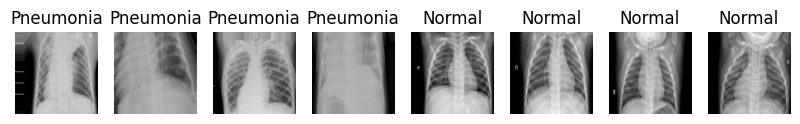

In [ ]:
def show_images(generator, num_images = 5):
    images, labels = next(generator)
    plt.figure(figsize=(10,10))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        plt.title('Normal' if labels[i] == 0 else 'Pneumonia')
        plt.axis('off')
    plt.show()
show_images(train_generator, num_images=8)

In [ ]:
# model
base_model = tf.keras.applications.ResNet50V2(input_shape=(image_size,image_size,3),
                                              include_top=False,
                                              weights='imagenet',
                                              pooling='avg')
inputs = base_model.input
x = tf.keras.layers.Dense(128, activation='relu')(base_model.output)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs,outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                            

 **ReduceLROnPlateau**  
*  이 콜백은 학습 중에 학습률(learning rate)을 동적으로 조절하여 모델의 성능을 향상시키는 데 사용

 * monitor: 모니터할 지표를 지정합니다. 여기서는 'val_loss'를 지정하여 검증 손실을 모니터링합니다.
* mode: 모니터링된 지표의 감소를 어떻게 해석할지를 지정합니다. 'min'으로 설정하면 모니터링된 지표가 감소할 때 학습률이 조정됩니다.
* factor: 학습률을 감소시키는 요인을 지정합니다. 현재 학습률에 이 요인을 곱하여 새로운 학습률을 얻습니다.
* patience: 지정된 수의 epoch 동안 지표가 개선되지 않을 때까지 기다리는 것을 지정합니다. 개선이 없을 경우 학습률이 조정됩니다.
* min_lr: 학습률이 감소할 수 있는 하한을 지정합니다. 학습률이 이 값을 더 이상 감소하지 않습니다.


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate= learning_rate)

LRS = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min',
                        factor = 0.1, patience = 3, min_lr = 1e-7)

# min_lr LR 감소 함계치
# mode Monitor 가 낮아지걸 기준으로 ? 아니면 높아지는 걸 기준으로 patience?
# factor 몇 퍼센트 비율로 LR 감소 시킬지
MC = ModelCheckpoint('checkpoint.tf', monitor = ' val_loss', mode = 'min', save_best_only = True)

ES = EarlyStopping(monitor = 'val_loss', patience = 5)

In [ ]:
model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data= validation_generator,
                    callbacks=[LRS,MC,ES])

Epoch 1/15
131/131 [==============================] - ETA: 0s - loss: 0.1563 - accuracy: 0.9437 

131/131 [==============================] - 2479s 19s/step - loss: 0.1563 - accuracy: 0.9437 - val_loss: 0.5878 - val_accuracy: 0.9358 - lr: 5.0000e-04
Epoch 2/15
131/131 [==============================] - ETA: 0s - loss: 0.1195 - accuracy: 0.9576 

131/131 [==============================] - 2493s 19s/step - loss: 0.1195 - accuracy: 0.9576 - val_loss: 0.5596 - val_accuracy: 0.8955 - lr: 5.0000e-04
Epoch 3/15
 20/131 [===>..........................] - ETA: 32:01 - loss: 0.0660 - accuracy: 0.9758

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='confusionmatrix'):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[: , np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i , cm[i,j],
                 horizontalalignment='center',
                 color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('GT')
    plt.xlabel('prediction')


In [ ]:
!mv /content/checkpoint.tf /content/drive/MyDrive/checkpoint.tf

In [ ]:
model.load_weights('/content/checkpoint.tf')
prediction = model.predict(test_generator)
predicted_classes = (prediction > 0.5).astype('int').reshape(-1)
true_classes = test_generator.classes
class_labels = test_generator.class_indices.keys()

conf_matrix = confusion_matrix(true_classes, predicted_classes)

In [ ]:
plot_confusion_matrix(conf_matrix,classes=class_labels, title='confusion_matrix')

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(true_classes, predicted_classes,
                               target_names = class_labels)
print(report)

In [ ]:
'''
projfolder
---- model/
------- model.py
------- submodel.py(Multi modal)
------- train.py
------- eval.py

---- data/
-------cv2(resize,convert)
-------norm.py
-------Tokenizing.py(NLP)
-------embedding.py(NLP)

---- utils/
--------NMS.py
--------distance.py
--------IOU.py

---- train.py(option) ->arg.xml
'''

'\nprojfolder\n---- model/\n------- model.py\n------- submodel.py(Multi modal)\n------- train.py\n------- eval.py\n\n---- data/\n-------cv2(resize,convert)\n-------norm.py\n-------Tokenizing.py(NLP)\n-------embedding.py(NLP)\n\n---- utils/\n--------NMS.py\n--------distance.py\n--------IOU.py\n\n---- train.py(option) ->arg.xml\n'

In [ ]:
import matplotlib.cm as cm
def make_gradcam_heatmap(img_array, model,last_conv_layer_name, pred_index=None):
  #img_array :  predict가 될, 이미지(array 형태로 입력)
  # model: test를 진행할 학습이 된 모델
  # last_conv_layer_name :  grad시각화를 진행할 레이어 이름
  # pred_index 히트맵이 생설 될 클래스 인데스  None일 경우 , 가장 높은 예측 점수를 가진 클래스가 사용 될 예정

  # 모델 구조 변경
    grad_model = tf.keras.models.Model(inputs=[model.inputs], outputs=[model.get_layer(last_conv_layer_name).output,model.output])
    with tf.GradientTape() as tape:
      last_conv_layer_output, pred = grad_model(img_array)
      if pred_index is None:
          pred_index = tf.argmax(pred[0])
      class_channel = pred[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled = tf.reduce_mean(grads, axis = (0, 1, 2))  # output은 텐서로 나온다.

    last_conv_layer_output = last_conv_layer_output[0]

    heatmap = last_conv_layer_output @ pooled[... , tf.newaxis]
    # 행렬곱 @, dotproduct *
    # pooled[... , tf.newaxis] = 벡터를 2D 행렬로 변환, 채널의 중요도가 한 열을 이루는 행렬
    # ex ) [3]의 벡터가 있다면, [3,1]
    # 곱셈의 결과는 모든 feature맵에 대해 중요도에 따라 가중치를 곱하여 하나의 히트맵을 생성
    # 히트맵은 어떤 부분이 ㄱ

    heatmap = tf.squeeze(heatmap)  # tensor to matrix
    # [높이,너비,1] -> [높이, 너비]

    heatmap = tf.maximum(heatmap)


In [ ]:
def overlay_heatmap_on_image(heatmap, img):
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap('jet')
    jet_color = jet(np.arange(256))[: , :3]
    jet_heatmap = jet_color[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_image(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * 0.005 + img
    superimposed_img = tf.keras.preprocessing.img_to_array(superimposed_img)
    return superimposed_img


In [ ]:
last_conv_layer_name = 'post_relu'

fig, ax = plt.subplots(4,4, figsize=(12,12))
for i in range(4):
    for j in range(4):
        img, label = test_generator.next()
        img = img[0]
        class_idx = np.argmax(label[0])
        class_name = class_labels[class_idx]
        heatmap = make_gradcam_heatmap(np.array([img]), model, last_conv_layer_name)
        superimposed_img = overlay_heatmap_on_image(heatmap, img)
        ax[i,j].imshow(superimposed_img)
        ax[i,j].set_title(class_name)
        ax[i,j].axis('off')
plt.tight_layout()
plt.show()